## Imports / Helper Functions / Global Variables

In [2]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from typing import List
from collections import Counter
import seaborn as sns
from tqdm import tqdm

In [3]:
# shorthand for datetime column

DATE_COL = 'Citation Issued DateTime'

In [4]:
# datetime manipulation helper functions

def filter_by_date_range(df: pd.DataFrame, column_name: str, start_string: str, end_string: str):
    return df[(df[column_name] >= pd.Timestamp(start_string)) & (df[column_name] <= pd.Timestamp(end_string))]

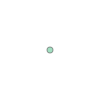

In [5]:
# helper functions for loading in US Census Bureau Geocoding data. This helps correct for ~10k observations with incorrect geolocation.

# 1ST -> 01ST, 2ND -> 02ND, etc., to be compatible
def inv_correct_numbered_streets(string):
    for i in range(1, 10):
        string = string.replace(f'{i}TH', f'0{i}TH')
    # 1st, 2nd and 3rd are special cases
    string = string.replace('1ST', '01ST')
    string = string.replace('2ND', '02ND')
    string = string.replace('3RD', '03RD')
    return string

def coord_string_to_point(coord_string):
    x, y = [float(string) for string in coord_string.split(',')]
    return Point(x, y)

coord_string_to_point("-122.46164710599999,37.77421091000008")

In [ ]:
# TODO: correct all "lock Of" addresses.

# feat_df[feat_df.street_id.str.contains('lock Of')]

In [6]:
def load_geocoder_data(csv_path='../data/chinook_ct_correct.csv'):
    geo = pd.read_csv(csv_path, header=None)
    geo = geo[geo[2] == 'Match']
    geo[1] = geo[1].str.replace(', SAN FRANCISCO, CA,', '').apply(lambda x: x.strip())
    geo = geo[[1, 5]]
    geo.columns = ['street', 'geom']
    geo.street = geo.street.apply(inv_correct_numbered_streets)
    geo.geom = geo.geom.apply(coord_string_to_point)
    return geo

## Load Data and Fix Incorrect Data

In [7]:
geo_df = load_geocoder_data()
geo_df.head()

,street,geom
0,785 04TH AVE,POINT (-122.46164710599999 37.77421091000008)
1,756 08TH AVE,POINT (-122.46593421399996 37.77422294300004)
2,277 05TH AVE,POINT (-122.46339279499995 37.783491569000034)
3,404 08TH AVE,POINT (-122.46639889099998 37.78064289800005)
4,398 05TH ST,POINT (-122.40188964199996 37.77906450900008)


In [8]:
# create dictionary from pandas dataframe. 

geo_dict = pd.Series(geo_df.geom.values,index=geo_df.street).to_dict()

In [277]:
geo_df.shape

(2500, 2)

In [9]:
df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,2022-04-20 12:10:00,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
1,952126114,2022-06-17 16:12:00,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
2,950441903,2022-04-23 15:13:00,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
3,948460144,2022-02-22 11:54:00,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
4,948169644,2022-02-17 13:39:00,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)


In [15]:
# filter to only meter violations

df = df[(df["Violation Description"].str.contains("METER")) | (df["Violation Description"].str.contains("MTR"))]

In [16]:
df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [17]:
# TODO: rewrite this using np.where or pandas where 
# TODO: use a better geocoder to fix more rows.

def fix_geom(row):
    if row['Citation Location'] in geo_dict:
        return geo_dict[row['Citation Location']]
    return row['geom']

df['geom'] = df.apply(fix_geom, axis=1)

## Add / Modify Dataframe Columns

In [18]:
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

In [19]:
# add auxillary date attribute columns based on the datetime. 

df['citation_day'] = df[DATE_COL].dt.day_name()
df['citation_hour'] = df[DATE_COL].dt.hour
df['citation_date'] = df[DATE_COL].dt.date

In [20]:
has_location_string = df[~df['Citation Location'].isnull()]

## Spatial Join

In [21]:
# load dataframe of street segments

street_df = pd.read_csv('../data/street_sweeping.csv')
street_df = street_df[~street_df.Line.isnull()]
street_df.loc[:, 'Line'] = street_df.Line.apply(wkt.loads)
street_df = gpd.GeoDataFrame(street_df, geometry='Line')
street_df.crs = 'EPSG:4326'

In [22]:
# TODO: technically should project into a flat geometry in order to get more accurate distances  

# unique_streets = street_df.drop_duplicates(subset='Line')
# unique_streets = unique_streets[['Corridor', 'Limits', 'Line']]

# # save copy of geom column because it will be destroyed by projection / join.
# unique_streets['street_geom_3d'] = unique_streets['Line']
# unique_streets['street_length'] = unique_streets.street_geom_3d.apply(lambda x: x.length)

unique_streets = pd.read_csv("../data/unique_streets.csv")

unique_streets['geom'] = unique_streets.Line.apply(wkt.loads)
unique_streets = gpd.GeoDataFrame(unique_streets, geometry='geom')
unique_streets.crs = 'EPSG:4326'

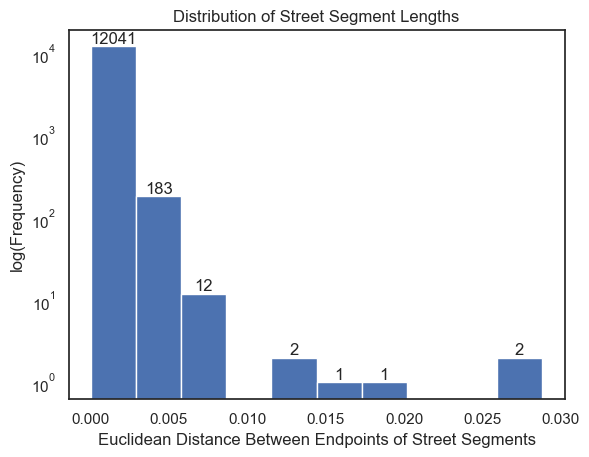

In [23]:
sns.set()
sns.set_theme(style='white')
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 0})
ax = unique_streets.street_length.plot(kind="hist", logy = True)
ax.bar_label(ax.containers[0], label_type="edge");

plt.xlabel("Euclidean Distance Between Endpoints of Street Segments")
plt.ylabel("log(Frequency)")
plt.title("Distribution of Street Segment Lengths");
plt.show()
sns.reset_orig()


In [24]:
joined = gpd.sjoin_nearest(df, unique_streets, distance_col='dist', how='left')
joined.shape

/Users/tessa/opt/anaconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


(181590, 21)

In [25]:
# TODO: figure out how to resolve points that get mapped to multiple streets. for now, seems like only a small number have this problem so we ignore it.

has_multiple_citations = joined['Citation Number'].value_counts()
joined = joined[joined['Citation Number'].isin(has_multiple_citations[has_multiple_citations == 1].index)]

## Group and Cluster

In [26]:
joined['street_id'] = joined['Corridor'] + ' ' + joined['Limits']

In [27]:
feat_df = joined[['citation_date', 'street_id', DATE_COL, 'Citation Location', 'geom', 'citation_day', 'citation_hour', 'street_geom_3d']]

In [28]:

unique_streets = pd.read_csv('../data/street_sweeping.csv')
unique_streets = unique_streets[~unique_streets.Line.isnull()]
unique_streets.loc[:, 'Line'] = unique_streets.Line.apply(wkt.loads)
unique_streets = gpd.GeoDataFrame(unique_streets, geometry='Line')
unique_streets.crs = 'EPSG:4326'

In [29]:
unique_streets

,CNN,Corridor,Limits,CNNRightLeft,BlockSide,FullName,WeekDay,FromHour,ToHour,Week1,Week2,Week3,Week4,Week5,Holidays,BlockSweepID,Line
0,9102000,Mission St,Julia St - 08th St,L,SouthEast,Thursday,Thu,2,6,1,1,1,1,1,1,1618894,"LINESTRING (-122.41241 37.77805, -122.41316 37..."
1,1191000,22nd St,Mission St - Bartlett St,L,South,Friday,Fri,6,8,1,1,1,1,1,0,1627862,"LINESTRING (-122.41875 37.75544, -122.41986 37..."
2,4331000,Congdon St,Maynard St - Silver Ave,L,East,Wednesday,Wed,11,13,1,1,1,1,1,0,1637394,"LINESTRING (-122.42602 37.72940, -122.42596 37..."
3,12043000,Sparta St,Ankeny St - Harkness Ave,R,West,Friday,Fri,12,15,1,1,1,1,1,0,1611118,"LINESTRING (-122.40355 37.71834, -122.40347 37..."
4,7602000,Jones St,Beach St - Jefferson St,R,East,Thursday,Thu,2,6,1,1,1,1,1,0,1616072,"LINESTRING (-122.41726 37.80707, -122.41745 37..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37873,9194000,Mission St,Laura St - Oliver St,L,South,Friday,Fri,6,8,1,1,1,1,1,0,1626558,"LINESTRING (-122.45010 37.70968, -122.45050 37..."
37874,13059000,Valencia St,Sparrow St - 16th St,R,West,Saturday,Sat,6,8,1,1,1,1,1,0,1598800,"LINESTRING (-122.42196 37.76572, -122.42189 37..."
37875,2299000,Annie St,Jessie St - Ambrose Bierce St,R,SouthWest,Friday,Fri,0,2,1,1,1,1,1,0,1635482,"LINESTRING (-122.40182 37.78727, -122.40178 37..."
37876,11957201,Sloat Blvd,Everglade Dr - Lakeshore Plz,R,North,Wed 2nd & 4th,Wed,8,10,0,1,0,1,0,0,1642048,"LINESTRING (-122.48896 37.73411, -122.48909 37..."


In [30]:
unique_streets[['X1', 'Y1']] = unique_streets['Line'].apply(lambda x: pd.Series([x.coords[0][0], x.coords[0][1]]))
unique_streets[['X2', 'Y2']] = unique_streets['Line'].apply(lambda x: pd.Series([x.coords[1][0], x.coords[1][1]]))

unique_streets['Endpoint1'] = unique_streets['X1'].astype(str) + " " + unique_streets['Y1'].astype(str)
unique_streets['Endpoint2'] = unique_streets['X2'].astype(str) + " " + unique_streets['Y2'].astype(str)

In [31]:
unique_streets['segment_id'] = unique_streets['Corridor'] + ' ' + unique_streets['Limits']

In [32]:
def get_intersect_st(df, segment_id):
    # getting endpoints of initial condition
    Endpoint1 = df[df['segment_id'] == segment_id]['Endpoint1'].iloc[0]
    Endpoint2 = df[df['segment_id'] == segment_id]['Endpoint2'].iloc[0]

    # now we need to get the segment_id's of streets that share the same endpoints
    unique_segments1 = df[(df['Endpoint1'] == Endpoint1) | (df['Endpoint1'] == Endpoint2)]['segment_id'].unique()
    unique_segments2 = df[(df['Endpoint2'] == Endpoint1) | (df['Endpoint2'] == Endpoint2)]['segment_id'].unique()

    # now return a concatonated list of segments into one vector
    unique_segments = np.unique(np.concatenate((unique_segments1, unique_segments2)))

    # Remove current segment from intersection
    unique_segments = unique_segments[unique_segments != segment_id]

    return(unique_segments)

get_intersect_st(unique_streets, '22nd St Mission St  -  Bartlett St')

array(['22nd St Bartlett St  -  Valencia St',
       '22nd St Capp St  -  Mission St',
       'Bartlett St 21st St  -  22nd St',
       'Bartlett St 22nd St  -  23rd St',
       'Mission St 21st St  -  22nd St', 'Mission St 22nd St  -  23rd St'],
      dtype=object)

In [33]:
unique_streets['adjacent_streets'] = unique_streets['segment_id'].apply(lambda segment_id: get_intersect_st(unique_streets, segment_id))

KeyboardInterrupt: 

In [ ]:
adjacent_dict = pd.Series(unique_streets.adjacent_streets.values,index=unique_streets.segment_id).to_dict()

In [34]:
feat_df['time_bin'] = feat_df[DATE_COL].dt.floor("15min").dt.time.astype(str)

/Users/tessa/opt/anaconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [252]:
feat_df

,citation_date,street_id,Citation Issued DateTime,Citation Location,geom,citation_day,citation_hour,street_geom_3d,time_bin
0,2022-04-20,Polk St Union St - Filbert St,2022-04-20 12:10:00,1318 FILBERT ST,POINT (-122.42120 37.80002),Wednesday,12,"LINESTRING (-122.422336950437 37.798761579363,...",12:00:00
1,2022-06-17,Polk St Union St - Filbert St,2022-06-17 16:12:00,1318 FILBERT ST,POINT (-122.42120 37.80002),Friday,16,"LINESTRING (-122.422336950437 37.798761579363,...",16:00:00
2,2022-04-23,Polk St Union St - Filbert St,2022-04-23 15:13:00,1318 FILBERT ST,POINT (-122.42120 37.80002),Saturday,15,"LINESTRING (-122.422336950437 37.798761579363,...",15:00:00
3,2022-02-22,Polk St Union St - Filbert St,2022-02-22 11:54:00,1318 FILBERT ST,POINT (-122.42120 37.80002),Tuesday,11,"LINESTRING (-122.422336950437 37.798761579363,...",11:45:00
4,2022-02-17,Polk St Union St - Filbert St,2022-02-17 13:39:00,1318 FILBERT ST,POINT (-122.42120 37.80002),Thursday,13,"LINESTRING (-122.422336950437 37.798761579363,...",13:30:00
...,...,...,...,...,...,...,...,...,...
1127678,2022-11-03,Clara St 05th St - 06th St,2022-11-03 08:26:00,928 HARRISON STREET,POINT (-122.40287 37.77869),Thursday,8,"LINESTRING (-122.402377491658 37.779458716037,...",08:15:00
1127680,2022-10-15,24th Ave Lake St - California St,2022-10-15 16:24:00,216 24TH AVE,POINT (-122.48398 37.78546),Saturday,16,"LINESTRING (-122.484079805605 37.785794530364,...",16:15:00
1127681,2022-10-11,30th Ave Geary Blvd - Anza St,2022-10-11 10:12:00,538 30TH AVE,POINT (-122.48981 37.77898),Tuesday,10,"LINESTRING (-122.490096579244 37.779839833304,...",10:00:00
1127684,2022-10-15,Avalon Ave Madrid St - Edinburg St,2022-10-15 12:41:00,191 MADRID ST,POINT (-122.42895 37.72634),Saturday,12,"LINESTRING (-122.429280199439 37.726281707576,...",12:30:00


In [35]:
# group by citation date
# for each adjacent street, we get all time bin values for that street on that day (in the group by)
# get new row based on current row, but replace time bin + duplicate 

def flatten(l):
    return [item for sublist in l for item in sublist]

def augment_group(group):
    unique_adjacent_streets = list(set(flatten(group.street_id.apply(lambda street_id: adjacent_dict[street_id]))))
    extra_rows = []
    for street in unique_adjacent_streets:
        adjacent_streets = adjacent_dict[street]
        extra = group[group['street_id'].isin(adjacent_streets)]
        extra['street_id'] = street
        extra_rows.append(extra)
    return extra_rows

In [36]:
# antipattern 
aug_list = []

for group_name, df_group in tqdm(feat_df.groupby('citation_date')):
    aug = augment_group(df_group)
    if len(aug) > 0:
        aug_list.extend(aug)

  0%|          | 0/412 [00:00<?, ?it/s]


NameError: name 'adjacent_dict' is not defined

In [ ]:
# antipattern!

augs = pd.concat(aug_list)

In [ ]:
feat_df = pd.concat([feat_df, augs])
feat_df.shape

In [37]:
all_bins = sorted(feat_df['time_bin'].unique())

In [38]:
# keep each entry for a particular time bin on a particular date + street

feat_df = feat_df.drop_duplicates(['citation_date', 'street_id', 'time_bin'])
binned_grouped = feat_df.groupby(['street_id', 'citation_day'])['time_bin'].agg(' '.join)

In [39]:
binned_grouped

street_id                         citation_day
01st St Elim St  -  Mission St    Friday               12:00:00 11:45:00 13:00:00 12:00:00 11:30:00
                                  Monday                                          12:00:00 14:30:00
                                  Thursday        12:30:00 12:15:00 11:15:00 12:15:00 11:00:00 1...
                                  Tuesday              11:45:00 11:00:00 13:00:00 12:30:00 14:15:00
                                  Wednesday                     14:15:00 12:15:00 12:15:00 12:00:00
                                                                        ...                        
Zoe St Freelon St  -  Brannan St  Monday                                          16:45:00 19:00:00
                                  Saturday                                                 14:00:00
                                  Thursday                      13:15:00 12:15:00 13:45:00 17:00:00
                                  Tuesday            

In [40]:
def bin_string_to_counter(bin_string):
    bin_counter = Counter(all_bins)
    bin_counter.update(bin_string.split(' '))
    return bin_counter

agg_counts = binned_grouped.apply(bin_string_to_counter).groupby(['street_id', 'citation_day']).sum()

In [41]:
agg_counts.iloc[10:17,]

street_id                           citation_day
01st St Guy Pl  -  Lansing St       Wednesday       {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
01st St Lansing St  -  Harrison St  Friday          {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                    Monday          {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                    Saturday        {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                    Thursday        {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                    Tuesday         {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                    Wednesday       {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
Name: time_bin, dtype: object

In [42]:
unique_street_names = agg_counts.index.get_level_values(0).unique()

In [43]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [ ]:
from datetime import date, timedelta

df.sort_values("Citation Issued DateTime").head()
sdate = date(2022,1,1)   # start date
edate = date(2023,2,20)   # end date
dates = pd.date_range(sdate, edate-timedelta(days=1),freq='d')
dates_counts = dates.day_name().value_counts().reindex(weekdays)

In [44]:
df_list = []

for name in tqdm(unique_street_names):
    t = agg_counts.xs(name, level=0, drop_level=False).reset_index().set_index('citation_day').reindex(weekdays, fill_value=Counter(all_bins))
    t.street_id = name
    dist_df = pd.concat([t.reset_index(), (pd.DataFrame.from_records(t.time_bin) - 1)], axis=1)# .divide(dates_counts.values, axis = 0)], axis=1)
    df_list.append(dist_df)

100%|██████████| 2162/2162 [00:05<00:00, 408.41it/s]


In [45]:
all_dists = pd.concat(df_list)

all_dists.head()

#all_dists.iloc[:, 3:] = np.log(all_dists.iloc[:, 3:]).replace(-np.Inf, np.nan).fillna(0)



,citation_day,street_id,time_bin,00:00:00,07:00:00,07:15:00,07:30:00,07:45:00,08:00:00,08:15:00,...,20:30:00,20:45:00,21:00:00,21:15:00,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00
0,Monday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Tuesday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wednesday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Thursday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Friday,01st St Elim St - Mission St,"{'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
all_dists[all_dists.street_id == '01st St Elim St  -  Mission St'].drop(['citation_day', 'street_id', 'time_bin'], axis=1).max().max()

3

In [59]:
all_dists.to_csv("../data/prob_e_and_i.csv", index = False)

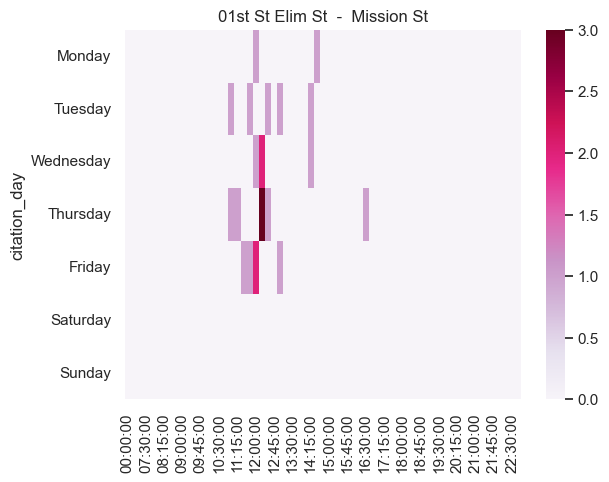

In [58]:

def plot_dist(all_dists, street_id):
    temp_df = all_dists[all_dists.street_id == street_id]
    #print(temp_df)
    # has all 7 days of the week
    assert temp_df.shape[0] == 7
    temp_df = temp_df[[col for col in temp_df.columns if col not in ['street_id', 'time_bin']]]
    temp_df.set_index('citation_day', inplace=True)
    sns.heatmap(temp_df, cmap = "PuRd").set(title=street_id)
plot_dist(all_dists, '01st St Elim St  -  Mission St')
plt.show()


In [55]:
street_id = all_dists['street_id'].value_counts().index[1000]

plot_dist(all_dists, street_id)

In [153]:
# looking for one street_id

# all_dists[all_dists.street_id.str.contains('Terry A Francois Blvd')].street_id[0]

In [157]:
NUMERIC_COLS = [col for col in all_dists.columns if '0' in col]

In [158]:
# add geom information to all_dists

unique_streets['street_id'] = unique_streets['Corridor'] + ' ' + unique_streets['Limits']
street_geom_dict = pd.Series(unique_streets.Line.values,index=unique_streets.street_id).to_dict()
all_dists['geom'] = all_dists['street_id'].apply(lambda key: street_geom_dict[key])

In [159]:
all_dists

,citation_day,street_id,time_bin,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,...,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00,geom
0,Monday,01st St Clementina St - Folsom St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.395007841381 37.787717615642,..."
1,Tuesday,01st St Clementina St - Folsom St,"{'00:00:00': 1, '00:15:00': 2, '00:30:00': 1, ...",0.0,0.016949,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.395007841381 37.787717615642,..."
2,Wednesday,01st St Clementina St - Folsom St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.395007841381 37.787717615642,..."
3,Thursday,01st St Clementina St - Folsom St,"{'00:00:00': 1, '00:15:00': 2, '00:30:00': 1, ...",0.0,0.016949,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.395007841381 37.787717615642,..."
4,Friday,01st St Clementina St - Folsom St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.395007841381 37.787717615642,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Wednesday,Zoe St Welsh St - Freelon St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.396306203949 37.780096449982,..."
3,Thursday,Zoe St Welsh St - Freelon St,"{'00:00:00': 1, '00:15:00': 13, '00:30:00': 9,...",0.0,0.203390,0.135593,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.396306203949 37.780096449982,..."
4,Friday,Zoe St Welsh St - Freelon St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016949,0.0,"LINESTRING (-122.396306203949 37.780096449982,..."
5,Saturday,Zoe St Welsh St - Freelon St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.396306203949 37.780096449982,..."


In [183]:
# equivalent to pivot_longer in R

pivoted = pd.melt(all_dists, id_vars=['citation_day', 'street_id', 'geom'], value_vars=NUMERIC_COLS, value_name='prob', var_name='time')
pivoted['time'] = pd.to_datetime(pivoted['time'])

In [184]:
pivoted = pivoted[pivoted["prob"] != 0]

In [185]:
days = {'Monday': timedelta(days=0), 'Tuesday': timedelta(days=1),
        'Wednesday': timedelta(days=2), "Thursday": timedelta(days=3),
        "Friday": timedelta(days=4), "Saturday": timedelta(days=5),
        "Sunday": timedelta(days=6)}

pivoted["time"] = pivoted.citation_day.apply(lambda x: days[x]) + pivoted["time"]

In [186]:
pivoted.head(10)

,citation_day,street_id,geom,time,prob
50,Tuesday,01st St Market St - Stevenson St,"LINESTRING (-122.399148598539 37.791016649255,...",2023-03-21,0.016949
192,Thursday,02nd St Dow Pl - Harrison St,"LINESTRING (-122.39589570128 37.78489692949, -...",2023-03-23,0.016949
204,Tuesday,02nd St Folsom St - Dow Pl,"LINESTRING (-122.396705177782 37.785542130693,...",2023-03-21,0.084746
206,Thursday,02nd St Folsom St - Dow Pl,"LINESTRING (-122.396705177782 37.785542130693,...",2023-03-23,0.016949
240,Wednesday,02nd St Minna St - Natoma St,"LINESTRING (-122.399255048484 37.787579277313,...",2023-03-22,0.016949
247,Wednesday,02nd St Mission St - Minna St,"LINESTRING (-122.399798024477 37.788007160065,...",2023-03-22,0.016949
249,Friday,02nd St Mission St - Minna St,"LINESTRING (-122.399798024477 37.788007160065,...",2023-03-24,0.016949
294,Monday,02nd St Townsend St - King St,"LINESTRING (-122.390527233758 37.780606757553,...",2023-03-20,0.118644
295,Tuesday,02nd St Townsend St - King St,"LINESTRING (-122.390527233758 37.780606757553,...",2023-03-21,0.050847
296,Wednesday,02nd St Townsend St - King St,"LINESTRING (-122.390527233758 37.780606757553,...",2023-03-22,0.084746


In [187]:
# save to csv for visualization by kepler GL

pivoted.to_csv('../data/pivoted_for_kgl.csv', index=False)

In [188]:
pivoted['prob'].value_counts()

0.016949    206199
0.033898     51622
0.016667     30045
0.050847     21306
0.067797     11176
             ...  
0.783333         2
0.850000         1
0.898305         1
0.916667         1
0.932203         1
Name: prob, Length: 105, dtype: int64

In [189]:
pivoted['prob'].min()

0.016666666666666666